In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('application_train.csv', header=0)

In [3]:
def classCountsInAnInterval(sub_df, interval):
    """ Returns the total number of instances of  paid/unpaid loans in a given interval """
    """ Input: Dataframe with class counts of the interval passed """
    class0, class1 = 0, 0
    # This check to handle cases where few intervals have only either paid/un-paid loans.
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [4]:
def getIntervalBasedCounts(df, category, no_of_bins=50):
    """ Input: A continous numerical category """
    """ Create bins from the category data points and count total loans, unpaid loans for each bin """
    
    # Create bins #
    continous_numerical_category = category
    binned_columns_name = continous_numerical_category + '_BINNED'
    credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['TARGET'], 
                                     continous_numerical_category: df[continous_numerical_category] })
    credit_and_loan_df[binned_columns_name] = pd.cut(credit_and_loan_df[continous_numerical_category], 
                                                     bins = np.linspace(
                                                         min(credit_and_loan_df[continous_numerical_category]), 
                                                         max(credit_and_loan_df[continous_numerical_category]), 
                                                         num = no_of_bins),
                                                     retbins=False)
    
    # Groupby "bin + loan_paid_status" and agg the size of each group.
    # This calculates the paid and unpaid loans counts in each bin.
    credit_and_loan_df = credit_and_loan_df.groupby([binned_columns_name, 'loan_paid_status']).size().to_frame()
    credit_and_loan_df.reset_index(inplace=True)
    credit_and_loan_df.set_index(binned_columns_name, inplace=True)
    
    # Binned column is of  type "Categorical Index" which is not useful in that format. #
    # Converting the bins to string format so that we can plot better based on bin. #
    integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
    credit_and_loan_df['integer_intervals'] = list(map(lambda interval: 
                                                       str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                       integer_intervals))
    credit_and_loan_df.reset_index(inplace=True)
    # Drop the bins column of type "Categorical Index"
    credit_and_loan_df = credit_and_loan_df.drop([binned_columns_name], axis=1)
    credit_and_loan_df.set_index('integer_intervals', inplace=True)
    credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
    
    # The dataframe looks like the following
    # bin1 - loan_paid_count
    # bin1 - loan_not_paid_count
    # bin2 - loan_paid_count
    # bin2 - loan_not_paid_count ...
    
    # Calculate the total loans and percentage of unpaid loans in each bin.
    totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(lambda interval: 
                                                                classCountsInAnInterval(
                                                                    credit_and_loan_df.loc[interval], interval), 
                                                                list(set(credit_and_loan_df.index)))), 
                                                       columns=['Total Loans', 'Unpaid Loans', 
                                                                continous_numerical_category])
    totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] 
                                                                      / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100
    return totalCountAndUnpaidCountPerInterval

In [5]:
def plotTotalAndUnpaidLoansPerBin(df, featureColumn, totalLoansColumn = "Total Loans", 
                                  unpaidLoansColumn = "Unpaid Loans", top_n_intervals=20, 
                                  figsize=(30, 30), transpose=False):
    """ Plots bins versus total number of loans and unpaid loans """
    total_axes_data = [featureColumn, totalLoansColumn]
    unpaid_axes_data = [featureColumn, unpaidLoansColumn]
    if transpose:
        total_axes_data[0], total_axes_data[1] = total_axes_data[1], total_axes_data[0]
        unpaid_axes_data[0], unpaid_axes_data[1] = unpaid_axes_data[1], unpaid_axes_data[0]
    sns.set(style="whitegrid")
    df = df.sort_values(totalLoansColumn, ascending=False).head(top_n_intervals)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Plot the total loans
    sns.set_color_codes("pastel")
    sns.barplot(x=total_axes_data[0], y=total_axes_data[1], data=df, label="Total", color="b")

    # Plot the loans which were unpaid
    sns.set_color_codes("muted")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=20)
    plt.ylabel('ylabel', fontsize=20)

    sns.barplot(x=unpaid_axes_data[0], y=unpaid_axes_data[1], data=df, label="Unpaid Loans", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=featureColumn, xlabel="Number of loans")
    sns.despine(left=True, bottom=True)

In [6]:
def plotPercentageUnpaidLoansPerBin(df, feature, top_n_intervals=20, figsize=(30, 30), transpose=False):
    """ Plots bins versus percentage of unpaid loans in that bin """
    font = {
        'weight' : 'bold',
        'size'   : 40
    }
    axes_data = [feature, 'percentage_unpaid_loans']
    if transpose:
        axes_data[0], axes_data[1] = axes_data[1], axes_data[0]
    matplotlib.rc('font', **font)
    f, axes = plt.subplots(1, 1, figsize=figsize)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=10)
    plt.ylabel('ylabel', fontsize=10)
    df = df.sort_values('percentage_unpaid_loans',  ascending=False).head(top_n_intervals)
    ax = sns.barplot(x=axes_data[0], y=axes_data[1], data=df, ax=axes)
    return df

In [7]:
def processCategoricalFeature(category):
    df_category = pd.DataFrame(df, columns=[category, 'TARGET'])
    df_category = df_category.groupby([category, 'TARGET']).size().to_frame()
    df_category.reset_index(inplace=True)
    df_category.set_index(category, inplace=True)
    df_category.rename(columns={0: "count"}, inplace=True)
    df_category.rename(columns={'TARGET': "loan_paid_status"}, inplace=True)
    df_category = pd.DataFrame(list(map(lambda interval: classCountsInAnInterval(df_category.loc[interval], interval), 
                                 list(set(df_category.index)))), 
                        columns=['Total Loans', 'Unpaid Loans', feature_name])
    df_category['percentage_unpaid_loans'] = (df_category['Unpaid Loans'] / df_category['Total Loans']) * 100
    return df_category

In [8]:
feature_name = "REGION_RATING_CLIENT_W_CITY"

In [9]:
feature_summary = processCategoricalFeature(feature_name)
feature_summary

,Total Loans,Unpaid Loans,REGION_RATING_CLIENT_W_CITY,percentage_unpaid_loans
0,34167,1654,1,4.840928
1,229484,18170,2,7.917763
2,43860,5001,3,11.402189


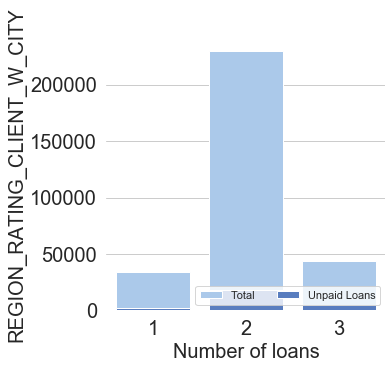

In [10]:
plotTotalAndUnpaidLoansPerBin(feature_summary, feature_name, figsize=(5,5))

,Total Loans,Unpaid Loans,REGION_RATING_CLIENT_W_CITY,percentage_unpaid_loans
2,43860,5001,3,11.402189
1,229484,18170,2,7.917763
0,34167,1654,1,4.840928


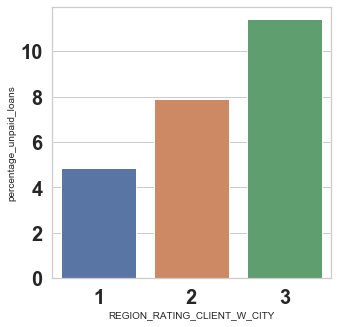

In [11]:
plotPercentageUnpaidLoansPerBin(feature_summary, feature_name, figsize=(5,5))